#**Load Dataset**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to ZIP file
zip_path = '/content/drive/MyDrive/pepper_bell.zip'

#Extract File
! unzip '/content/drive/MyDrive/pepper_bell.zip'

#**Classes**

In [2]:
import os

pepperbell_data = '/content/pepper_bell'
pepperbell_classes = os.listdir(pepperbell_data)

In [3]:
print("Pepper Bell Clases: ")
for classes in pepperbell_classes:
  if os.path.isdir(os.path.join(pepperbell_data, classes)):
    print(classes)

Pepper Bell Clases: 
Pepper__bell___healthy
Not__Pepper__bell
Pepper__bell___Bacterial_spot


#**Preprocessing Data**

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
import shutil
from PIL import Image

# Resize Dataset and Save to New Directory
resized_dir = "/content/drive/MyDrive/resized"
os.makedirs(resized_dir, exist_ok=True)

for item in pepperbell_classes:
  class_dir = os.path.join(pepperbell_data, item)
  class_images = os.listdir(class_dir)

  for img_path in class_images:
    img = Image.open(os.path.join(class_dir, img_path))
    resized_img = img.resize((256, 256))
    save_path = os.path.join(resized_dir, item, img_path) 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)  
    resized_img.save(save_path)

In [6]:
# Content of Resize Dataset
!ls '/content/drive/MyDrive/resized'

Not__Pepper__bell  Pepper__bell___Bacterial_spot  Pepper__bell___healthy


#**Preview Dataset**


Pepper__bell___healthy
Total Images: 1478
Resolution of First Image: (256, 256, 3)


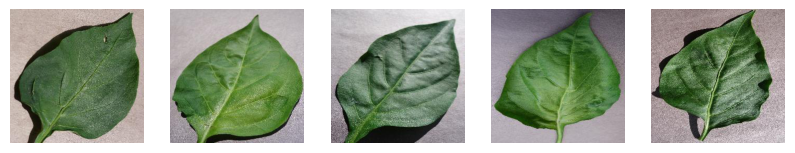


Not__Pepper__bell
Total Images: 802
Resolution of First Image: (256, 256, 3)


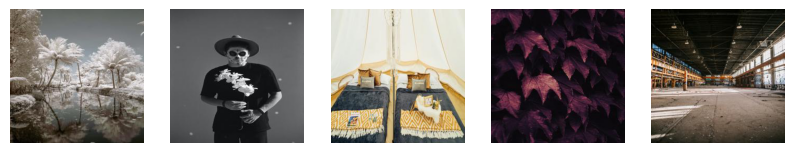


Pepper__bell___Bacterial_spot
Total Images: 997
Resolution of First Image: (256, 256, 3)


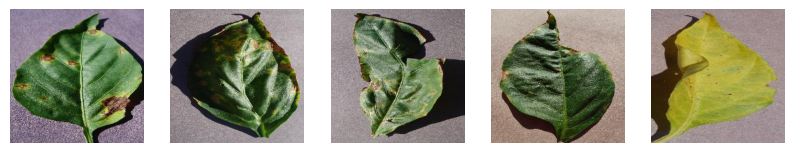

In [7]:
for item in pepperbell_classes:
  print("")
  print(item)
  class_dir = os.path.join(resized_dir, item)
  class_images = os.listdir(class_dir)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of First Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

#**Training anda Validation Generator**

In [8]:
# Create training and validation data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./256,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    )


train_generator = datagen.flow_from_directory(
    resized_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    resized_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

Found 2623 images belonging to 3 classes.
Found 654 images belonging to 3 classes.


#**Building Models**

In [9]:
import tensorflow as tf

# Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [10]:
# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history= model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/10
132/132 [==============================] - 76s 488ms/step - loss: 0.4973 - accuracy: 0.7758 - val_loss: 0.3102 - val_accuracy: 0.8761
Epoch 2/10
132/132 [==============================] - 60s 452ms/step - loss: 0.2796 - accuracy: 0.9089 - val_loss: 0.3100 - val_accuracy: 0.8869
Epoch 3/10
132/132 [==============================] - 57s 435ms/step - loss: 0.1615 - accuracy: 0.9508 - val_loss: 0.1325 - val_accuracy: 0.9557
Epoch 4/10
132/132 [==============================] - 58s 437ms/step - loss: 0.1639 - accuracy: 0.9482 - val_loss: 0.1569 - val_accuracy: 0.9419
Epoch 5/10
132/132 [==============================] - 58s 440ms/step - loss: 0.2223 - accuracy: 0.9344 - val_loss: 0.2268 - val_accuracy: 0.9174
Epoch 6/10
132/132 [==============================] - 59s 446ms/step - loss: 0.1405 - accuracy: 0.9543 - val_loss: 0.1290 - val_accuracy: 0.9587
Epoch 7/10
132/132 [==============================] - 59s 448ms/step - loss: 0.1107 - accuracy: 0.9706 - val_loss: 0.0931 - val_ac

#**Plot Accuracy And Loss**

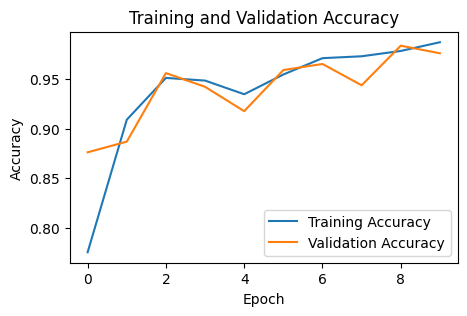

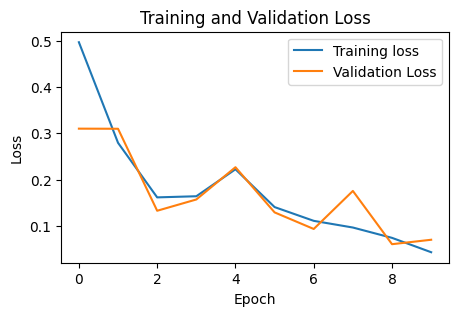

In [16]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**Testing**

Saving e8e03ae2-a11f-4af1-879b-66d71af9ba13___NREC_B.Spot 1857.JPG to e8e03ae2-a11f-4af1-879b-66d71af9ba13___NREC_B.Spot 1857 (1).JPG
1/1 [==============================] - 0s 18ms/step


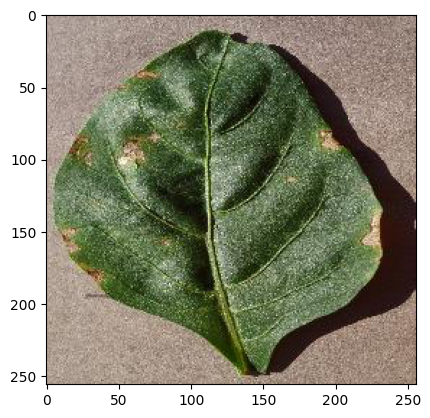

Not__Pepper__bell: 100.00%


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
from keras.applications.xception import preprocess_input

labels = list(train_generator.class_indices.keys())

upload = files.upload()

for fn in upload.keys():
    # Image Prediction
    path = fn
    img = image.load_img(path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    predictions = model.predict(images)[0]
    
    plt.imshow(img)
    plt.show()
      
    # Find Class with Highest percentage
    max_index = np.argmax(predictions)
    max_label = labels[max_index]
    max_percentage = predictions[max_index] * 100
    
    print("{}: {:.2f}%".format(max_label, max_percentage))


#**Saving Models**

In [27]:
# Save Final Model
model.save("corn_model_2.h5")
tf.keras.models.save_model(model, 'corn_model_2.hdf5')

In [28]:
#Convert TF Lite
import tensorflow as tf

#Load Saved Model
last_model = tf.keras.models.load_model(filepath="corn_model_2.h5")

#Convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(last_model)
model_tflite = converter.convert()

#Save TF Lite model
with tf.io.gfile.GFile('corn_model_2.tflite', 'wb') as f:
  f.write(model_tflite)

In [29]:
# Save in JSON Format
model_json = model.to_json()
with open("model_tl_json", "w") as file_json:
    file_json.write(model_json)